Diseño e Implementación de un Control Difuso Mamdani
Implementación de robótica inteligente

Alumnos:
<br>Jonathan Arles Guevara Molina A01710380
<br>Ezzat Alzahouri Campos A01710709
<br>José Ángel Huerta Ríos A01710607
<br>Ricardo Sierra Roa A01709887

Equipo:
<br>Papuland

Profesor:
<br>Francisco Javier Navarro Barrón

Instituto Tecnológico y de Estudios Superiores de Monterrey
<br>Campus Querétaro

Fecha de entrega:
<br>12 de mayo de 2025


In [124]:
!pip install -q scikit-fuzzy scipy numpy matplotlib plotly

# Truck Backer-Upper Control Problem
Estacionar en reversa un camión hacia un muelle de carga es un ejercicio difícil. Se trata de un problema de *control no lineal* para el cual métodos tradicionales de diseño de sistemas de control pueden encontrar dificultades.

## Consideraciones
1. La posición del camión está determinada exactamente por las tres variables de estado $ϕ$, $x$ e $y$, donde $ϕ$ es el ángulo del camión con la horizontal como se muestra en la figura.
2. El control del camión es el ángulo $θ$. Solo se considera el retroceso. El camión se mueve hacia atrás una distancia fija en cada etapa.
3. Por simplicidad, asumimos suficiente espacio entre el camión y el muelle de carga de modo que $y$ no tiene que ser considerado como una entrada.

El reto aquí es diseñar un sistema de control difuso cuyas entradas sean $ϕ \in [−90°, 270°]$ y $x \in [0,20]$, y cuya salida sea $\theta \in [−40°, 40°]$, de tal manera que los estados finales sean $(x_f ,\phi_f ) = (10,90°)$.

## Diagrama de la zona de carga simulada del camión
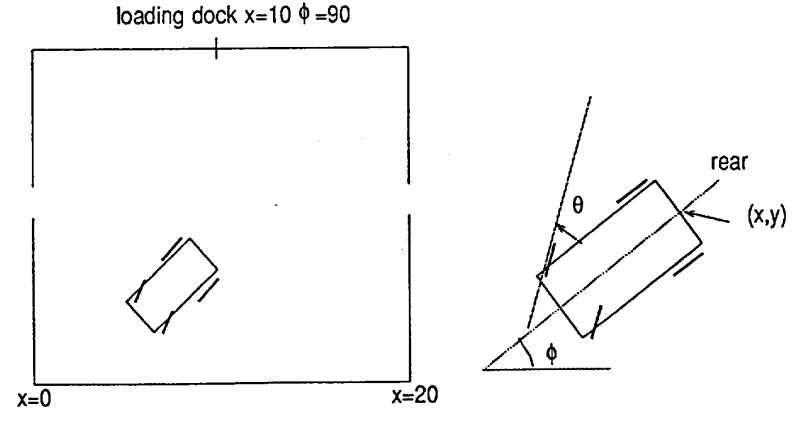

## Datos
Imagina que se le pidió a un conductor experimentado que nos ayudara a generar las mediciones de datos de entrada y salida "ideal", es decir, $(x,\phi,\theta)$ en diferentes estados $t$. De este modo, se recopilaron los siguientes datos con la trayectoria deseada comenzando desde $(x_0,\phi_0)=(1,0°)$

In [125]:
import numpy as np

# assume the data is ordered in the following order:
# ['t', 'x', 'phi', 'Theta']
data = np.array([[  0.  ,   1.  ,   0.  , -19.  ],
       [  1.  ,   1.95,   9.37, -17.95],
       [  2.  ,   2.88,  18.23, -16.9 ],
       [  3.  ,   3.79,  26.59, -15.85],
       [  4.  ,   4.65,  34.44, -14.8 ],
       [  5.  ,   5.45,  41.78, -13.75],
       [  6.  ,   6.18,  48.6 , -12.7 ],
       [  7.  ,   7.48,  54.91, -11.65],
       [  8.  ,   7.99,  60.71, -10.6 ],
       [  9.  ,   8.72,  65.99,  -9.55],
       [ 10.  ,   9.01,  70.75,  -8.5 ],
       [ 11.  ,   9.28,  74.98,  -7.45],
       [ 12.  ,   9.46,  78.7 ,  -6.4 ],
       [ 13.  ,   9.59,  81.9 ,  -5.34],
       [ 14.  ,   9.72,  84.57,  -4.3 ],
       [ 15.  ,   9.81,  86.72,  -3.25],
       [ 16.  ,   9.88,  88.34,  -2.2 ],
       [ 17.  ,   9.91,  89.44,   0.  ]])
data

array([[  0.  ,   1.  ,   0.  , -19.  ],
       [  1.  ,   1.95,   9.37, -17.95],
       [  2.  ,   2.88,  18.23, -16.9 ],
       [  3.  ,   3.79,  26.59, -15.85],
       [  4.  ,   4.65,  34.44, -14.8 ],
       [  5.  ,   5.45,  41.78, -13.75],
       [  6.  ,   6.18,  48.6 , -12.7 ],
       [  7.  ,   7.48,  54.91, -11.65],
       [  8.  ,   7.99,  60.71, -10.6 ],
       [  9.  ,   8.72,  65.99,  -9.55],
       [ 10.  ,   9.01,  70.75,  -8.5 ],
       [ 11.  ,   9.28,  74.98,  -7.45],
       [ 12.  ,   9.46,  78.7 ,  -6.4 ],
       [ 13.  ,   9.59,  81.9 ,  -5.34],
       [ 14.  ,   9.72,  84.57,  -4.3 ],
       [ 15.  ,   9.81,  86.72,  -3.25],
       [ 16.  ,   9.88,  88.34,  -2.2 ],
       [ 17.  ,   9.91,  89.44,   0.  ]])

### Consigna
En este Mini reto desarrollarán en equipo un Controlador Difuso el cual, dada la información proporcionada, genere las salidas que se aproximen a lo realizado por el conductor.

Puedes utilizar la estrategia de granulación que consideres pertinente así como los tipos de funciones de pertenencia que desees.

### Evaluación
Para medir el desempeño de tu sistema utilizarás la métrica RMSE (*Root Mean Squared Error*) definida como:

$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $

donde:
* $n$ es el número de puntos de datos.
* $y_i$ representa el valor real para el (i)-ésimo punto de datos.
* $\hat{y}_i$ representa el valor predicho para el (i)-ésimo punto de datos.

**Interpretación**: El RMSE mide la raíz cuadrada del promedio de los errores al cuadrado entre los valores reales y los valores predichos.
Cuanto menor sea el RMSE, mejor se ajustará el modelo a los datos observados.

In [126]:
def get_RMSE(real_values_list, predicted_value_list):
    return np.sqrt(np.square(np.subtract(real_values_list, predicted_value_list)).mean())

# Instalar librerias
pip install scikit-fuzzy


# Librerias

In [127]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Entradas y Salidas

In [128]:
# Entradas
x = ctrl.Antecedent(np.arange(0, 11, 0.1), 'x')
phi = ctrl.Antecedent(np.arange(0, 100, 1), 'phi')

# Salida
theta = ctrl.Consequent(np.arange(-20, 5, 0.1), 'theta')

# FUNCIONES DE PERTENENCIA

In [129]:
#   ─── ENTRADAS ───────────────────────────────────────────────
# x
x['low']    = fuzz.trimf(x.universe, [0, 0, 5])
x['medium'] = fuzz.trimf(x.universe, [2, 5, 8])
x['high']   = fuzz.trimf(x.universe, [5, 10, 10])

# φ
phi['small']  = fuzz.trimf(phi.universe, [0, 0, 45])
phi['medium'] = fuzz.trimf(phi.universe, [20, 50, 80])
phi['large']  = fuzz.trimf(phi.universe, [60, 100, 100])
phi['small']  = fuzz.trimf(phi.universe, [ 0,  0, 40])
phi['medium'] = fuzz.trimf(phi.universe, [30, 55, 75])
phi['large']  = fuzz.trimf(phi.universe, [65,100,100])

#   ─── SALIDA θ  (más granular) ───────────────────────────────
theta['negLarge']  = fuzz.trimf(theta.universe, [-20, -18, -14])
theta['negMedium'] = fuzz.trimf(theta.universe, [-17, -12, -7])
theta['negSmall']  = fuzz.trimf(theta.universe, [-10, -6, -2])
theta['zero']      = fuzz.trimf(theta.universe, [-4, -1,  1])
# θ  (°)   –tres niveles negativos, ninguno positivo–
theta['negBig']   = fuzz.trimf(theta.universe, [-20, -18, -14])   # para φ pequeño
theta['negMed']   = fuzz.trimf(theta.universe, [-15, -12,  -8])   # φ medio
theta['negSmall'] = fuzz.trimf(theta.universe, [-10,  -6,  -1])   # φ grande

# REGLAS DIFUSAS

In [130]:
rules = [

    # φ  small  (camión aún muy desviado ⇒ θ muy negativo)
    ctrl.Rule(x['low']    & phi['small'],  theta['negBig'  ]),
    ctrl.Rule(x['medium'] & phi['small'],  theta['negBig'  ]),
    ctrl.Rule(x['high']   & phi['small'],  theta['negMed'  ]),

    # φ  medium (empieza a enderezar ⇒ θ moderado)
    ctrl.Rule(x['low']    & phi['medium'], theta['negMed'  ]),
    ctrl.Rule(x['medium'] & phi['medium'], theta['negMed'  ]),
    ctrl.Rule(x['high']   & phi['medium'], theta['negSmall']),

    # φ  large  (casi alineado ⇒ θ poco negativo)
    ctrl.Rule(x['low']    & phi['large'],  theta['negSmall']),
    ctrl.Rule(x['medium'] & phi['large'],  theta['negSmall']),
    ctrl.Rule(x['high']   & phi['large'],  theta['negSmall']),
]


# SISTEMA DE CONTROL Y SIMULACIÓN

In [131]:
theta_ctrl = ctrl.ControlSystem(rules)
theta_sim = ctrl.ControlSystemSimulation(theta_ctrl)

# EVALUAR TODOS LOS DATOS Y PREDECIR

In [132]:
predicted_theta = []

for _, x_val, phi_val, _ in data:
    theta_sim.input['x'] = x_val
    theta_sim.input['phi'] = phi_val
    theta_sim.compute()
    predicted_theta.append(theta_sim.output['theta'])

# CALCULAR RMSE (PRECISIÓN)

In [133]:
true_theta = data[:, 3]
rmse = get_RMSE(true_theta, predicted_theta)
print(f'RMSE del sistema difuso: {rmse:.4f}')

RMSE del sistema difuso: 2.9447


# MOSTRAR TABLA DE RESULTADOS

In [134]:
import pandas as pd

resultados = pd.DataFrame({
    'x': data[:, 1],
    'phi': data[:, 2],
    'theta real': true_theta,
    'theta predicho': predicted_theta
})

print(resultados)

       x    phi  theta real  theta predicho
0   1.00   0.00      -19.00      -17.311111
1   1.95   9.37      -17.95      -17.260384
2   2.88  18.23      -16.90      -17.192988
3   3.79  26.59      -15.85      -17.156373
4   4.65  34.44      -14.80      -13.760558
5   5.45  41.78      -13.75      -10.232468
6   6.18  48.60      -12.70       -9.289912
7   7.48  54.91      -11.65       -6.980092
8   7.99  60.71      -10.60       -5.658616
9   8.72  65.99       -9.55       -5.601710
10  9.01  70.75       -8.50       -5.551020
11  9.28  74.98       -7.45       -5.567335
12  9.46  78.70       -6.40       -5.589920
13  9.59  81.90       -5.34       -5.607908
14  9.72  84.57       -4.30       -5.621704
15  9.81  86.72       -3.25       -5.631878
16  9.88  88.34       -2.20       -5.638917
17  9.91  89.44        0.00       -5.643356


# Surface view con Plotly

In [135]:
def surfaceView_fuzzy(theta_sim, input1Disc=100, input2Disc=100):
    # Crear listas para los ejes
    x_vals = np.linspace(0, 10, input1Disc)
    phi_vals = np.linspace(0, 100, input2Disc)

    z_vals = np.zeros((input2Disc, input1Disc))  # theta predicho

    for i, phi_val in enumerate(phi_vals):
        for j, x_val in enumerate(x_vals):
            theta_sim.input['x'] = x_val
            theta_sim.input['phi'] = phi_val
            try:
                theta_sim.compute()
                result = theta_sim.output['theta']
            except:
                result = 0.0
            z_vals[i][j] = result

    # Crear gráfico Plotly
    fig = go.Figure(data=[go.Surface(z=z_vals, x=x_vals, y=phi_vals)])

    fig.update_layout(title='Surface View del Controlador Difuso',
                      scene=dict(
                          xaxis_title='x',
                          yaxis_title='phi',
                          zaxis_title='theta (predicho)'
                      ),
                      autosize=True,
                      width=800,
                      height=600,
                      margin=dict(l=30, r=30, b=50, t=50))
    fig.show()

# Llamada a la función
surfaceView_fuzzy(theta_sim)
